In [1]:
!pip install kagglehub

In [1]:
print('jupyter working')

jupyter working


In [2]:
# import kagglehub
# import os
# import shutil

# # Set download path to data folder
# data_folder = "data"
# os.makedirs(data_folder, exist_ok=True)

# # Download latest version
# path = kagglehub.dataset_download("prathamhanda10/brats-2024-preprocessed-training-patches")

# print("Downloaded to:", path)

# # Move to data folder if not already there
# target_path = os.path.join(data_folder, "brats-2024-preprocessed-training-patches")
# if path != target_path and not os.path.exists(target_path):
#     shutil.move(path, target_path)
#     print(f"Moved to: {target_path}")
# else:
#     print(f"Dataset location: {path}")

Loading data/brats-2024-preprocessed/BraTS-GLI-01610-000_patch_0.npz...

Keys found in file: ['image', 'mask']
Image Data Shape: (4, 128, 128, 128)
Segmentation Data Shape: (128, 128, 128)


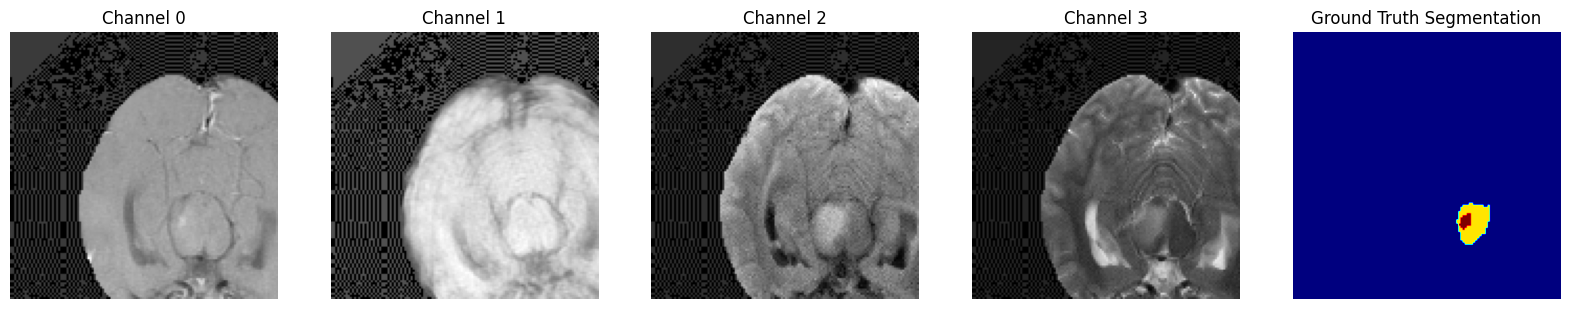


Labels found in this slice: [0 2 3]
(0=Background, 1=Necrotic, 2=Edema, 4=Enhancing Tumor)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def inspect_and_visualize(file_path):
    # 1. Load the file
    print(f"Loading {file_path}...")
    data = np.load(file_path)
    
    # 2. Inspect what is inside (the keys)
    # .npz files are like dictionaries. We need to know the key names (usually 'data', 'label')
    keys = list(data.keys())
    print(f"\nKeys found in file: {keys}")
    
    # ADJUST THESE KEYS if your dataset uses different names (e.g., 'image', 'mask')
    img_key = keys[0] # Guessing the first one is the image
    seg_key = keys[1] # Guessing the second one is the label
    
    # Explicitly check for common names to be safe
    if 'data' in keys: img_key = 'data'
    if 'label' in keys: seg_key = 'label'
        
    img_volume = data[img_key] 
    seg_volume = data[seg_key]
    
    print(f"Image Data Shape: {img_volume.shape}")
    print(f"Segmentation Data Shape: {seg_volume.shape}")
    
    # 3. Handle Dimensions (C, D, H, W) vs (D, H, W, C)
    # BraTS usually comes as (Channels, Depth, Height, Width) -> (4, 128, 128, 128)
    
    # We want to grab the MIDDLE slice to visualize
    if img_volume.shape[0] == 4:
        # Format is (Channels, Depth, Height, Width)
        depth = img_volume.shape[1]
        mid_idx = depth // 2
        
        # Extract the 4 channels for this slice
        # shape becomes (4, 128, 128)
        slice_imgs = img_volume[:, mid_idx, :, :] 
        
        # Extract the mask (check if it has a channel dim)
        if seg_volume.ndim == 4:
            slice_mask = seg_volume[0, mid_idx, :, :]
        else:
            slice_mask = seg_volume[mid_idx, :, :]
            
    else:
        # Format might be (Depth, Height, Width, Channels)
        depth = img_volume.shape[0]
        mid_idx = depth // 2
        
        # Transpose so we have (4, 128, 128) for easier plotting
        slice_imgs = img_volume[mid_idx, :, :, :].transpose(2, 0, 1)
        slice_mask = seg_volume[mid_idx, :, :]

    # 4. Plotting
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    # Standard BraTS Channel Order: T1, T1ce, T2, FLAIR (Check your specific dataset readme)
    channel_names = ['Ch0', 'Ch1', 'Ch2', 'Ch3'] 
    
    for i in range(4):
        axes[i].imshow(slice_imgs[i], cmap='gray')
        axes[i].set_title(f"Channel {i}")
        axes[i].axis('off')
        
    # Plot the Segmentation Mask
    # We use 'jet' colormap so different tumor classes show as different colors
    axes[4].imshow(slice_mask, cmap='jet') 
    axes[4].set_title("Ground Truth Segmentation")
    axes[4].axis('off')
    
    plt.show()
    
    # 5. Check what classes are in this specific slice
    unique_labels = np.unique(slice_mask)
    print(f"\nLabels found in this slice: {unique_labels}")
    print("(0=Background, 1=Necrotic, 2=Edema, 4=Enhancing Tumor)")

# --- USAGE ---
# Replace 'your_file.npz' with the actual path to one of your downloaded files
inspect_and_visualize('data/brats-2024-preprocessed/BraTS-GLI-01610-000_patch_0.npz')

In [9]:
!pip install nibabel matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.3 MB ? eta -:--:--Downloading nibabel-5.2.1-py3-none-any.whl (3.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.1 MB/s eta 0:00:00a 0:00:01


Processing Patient: BraTS2021_00046
Showing Slice 96 (Slice with largest tumor area)


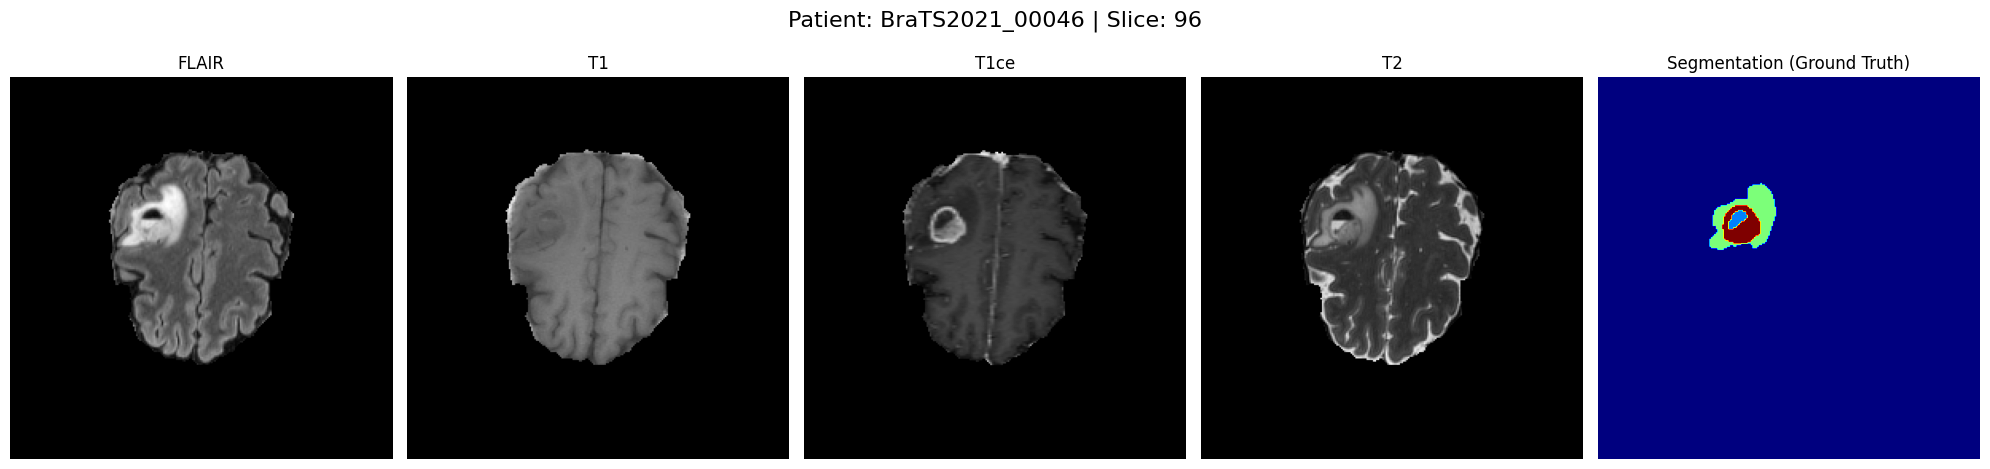

In [12]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def visualize_brats_patient(patient_folder_path):
    """
    Visualizes all 4 modalities and the segmentation mask for a single BraTS 2021 patient.
    """
    # 1. Get the Patient ID from the folder name (e.g., "BraTS2021_00621")
    patient_id = os.path.basename(patient_folder_path)
    print(f"Processing Patient: {patient_id}")
    
    # 2. Define the file paths based on the standard BraTS naming convention
    # Structure: {PatientID}_{Modality}.nii.gz
    # We join the folder path with the specific filename
    paths = {
        'FLAIR': os.path.join(patient_folder_path, f"{patient_id}_flair.nii.gz"),
        'T1':    os.path.join(patient_folder_path, f"{patient_id}_t1.nii.gz"),
        'T1ce':  os.path.join(patient_folder_path, f"{patient_id}_t1ce.nii.gz"),
        'T2':    os.path.join(patient_folder_path, f"{patient_id}_t2.nii.gz"),
        'Seg':   os.path.join(patient_folder_path, f"{patient_id}_seg.nii.gz")
    }

    # 3. Load the data
    # We use a dictionary to store the loaded 3D volumes
    volumes = {}
    try:
        for name, path in paths.items():
            if os.path.exists(path):
                img = nib.load(path)
                volumes[name] = img.get_fdata() # Convert to numpy array
            else:
                print(f"Warning: File not found {path}")
                return
    except Exception as e:
        print(f"Error loading files: {e}")
        return

    # 4. Find the "Best" Slice
    # Instead of just taking the middle, let's find the slice with the BIGGEST tumor
    # This ensures we don't plot a blank screen.
    seg_volume = volumes['Seg']
    
    # Count non-zero pixels in each slice along the Z-axis (depth)
    # The shape is usually (240, 240, 155) -> (Height, Width, Depth)
    z_axis = 2 
    tumor_counts = np.count_nonzero(seg_volume, axis=(0, 1))
    
    # Get the index of the slice with the most tumor
    max_tumor_idx = np.argmax(tumor_counts)
    
    # If the mask is empty (no tumor labeled yet), just take the middle
    if tumor_counts[max_tumor_idx] == 0:
        print("No tumor found in segmentation mask (or empty mask). Showing middle slice.")
        max_tumor_idx = seg_volume.shape[z_axis] // 2
    else:
        print(f"Showing Slice {max_tumor_idx} (Slice with largest tumor area)")

    # 5. Plotting
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    # Order we want to display
    display_order = ['FLAIR', 'T1', 'T1ce', 'T2', 'Seg']
    
    for i, modality in enumerate(display_order):
        # Extract the specific slice
        # Note: BraTS data is usually (H, W, D), so we slice the last dimension
        slice_img = volumes[modality][:, :, max_tumor_idx]
        
        # Rotate it 90 degrees because NIfTI loads sideways usually
        slice_img = np.rot90(slice_img)
        
        if modality == 'Seg':
            axes[i].imshow(slice_img, cmap='jet') # Color map for labels
            axes[i].set_title("Segmentation (Ground Truth)")
        else:
            axes[i].imshow(slice_img, cmap='gray')
            axes[i].set_title(f"{modality}")
            
        axes[i].axis('off')

    plt.suptitle(f"Patient: {patient_id} | Slice: {max_tumor_idx}", fontsize=16)
    plt.tight_layout()
    plt.show()

# --- USAGE ---
# Update this path to point to ONE specific patient folder inside your 'data' folder
# Example: "data/brats-2021-task1/BraTS2021_00621"
folder_path = 'data/brats-2021-task1/BraTS2021_Training_Data/BraTS2021_00046' 

# Check if path exists before running to avoid errors
if os.path.exists(folder_path):
    visualize_brats_patient(folder_path)
else:
    print(f"Please update the 'folder_path' variable. Could not find: {folder_path}")

In [13]:
import os
import random
import numpy as np
import nibabel as nib
import cv2

def normalize_to_255(img_data):
    """
    Normalizes MRI pixel values (which can be anything) to 0-255 for JPG images.
    """
    if np.max(img_data) == 0:
        return img_data # Avoid division by zero
    img_data = img_data - np.min(img_data)
    img_data = img_data / np.max(img_data)
    return (img_data * 255).astype(np.uint8)

def get_yolo_bbox(mask_slice, class_id=0):
    """
    Finds the bounding box of the tumor in the mask and converts it to YOLO format:
    <class_id> <x_center> <y_center> <width> <height> (all normalized 0-1)
    """
    # Find all pixels that are NOT background (value > 0)
    # Note: In BraTS, labels are 1, 2, 4. We treat them all as "Tumor" here.
    coords = np.argwhere(mask_slice > 0)
    
    if len(coords) == 0:
        return None # No tumor in this slice

    # Get bounding box coordinates (y, x)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    
    # Image dimensions
    h, w = mask_slice.shape
    
    # Calculate Center and Width/Height
    # (x_max + x_min) is sum of indices, divide by 2 for center, then by w for normalization
    x_center = ((x_min + x_max) / 2) / w
    y_center = ((y_min + y_max) / 2) / h
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def process_one_patient(patient_path, output_dir):
    patient_id = os.path.basename(patient_path)
    print(f"Processing: {patient_id}")
    
    # 1. Define Paths
    files = {
        'flair': os.path.join(patient_path, f"{patient_id}_flair.nii.gz"),
        't1':    os.path.join(patient_path, f"{patient_id}_t1.nii.gz"),
        't1ce':  os.path.join(patient_path, f"{patient_id}_t1ce.nii.gz"),
        't2':    os.path.join(patient_path, f"{patient_id}_t2.nii.gz"),
        'seg':   os.path.join(patient_path, f"{patient_id}_seg.nii.gz")
    }
    
    # 2. Load Segmentation Mask First to find a slice
    try:
        seg_img = nib.load(files['seg']).get_fdata()
    except FileNotFoundError:
        print("Segmentation file not found. Skipping.")
        return

    # 3. Pick a Random Slice
    # BraTS shape is usually (240, 240, 155). We slice the last dim (depth).
    # Find all slice indices (z) that have some tumor (mask > 0)
    z_indices_with_tumor = np.where(np.any(seg_img > 0, axis=(0,1)))[0]
    
    if len(z_indices_with_tumor) > 0:
        slice_idx = random.choice(z_indices_with_tumor)
        print(f"  -> Selected Slice {slice_idx} (contains tumor)")
    else:
        # Fallback if no tumor found (e.g., healthy patient)
        total_slices = seg_img.shape[2]
        slice_idx = random.randint(int(total_slices*0.3), int(total_slices*0.7))
        print(f"  -> No tumor found. Selected random middle Slice {slice_idx}")

    # 4. Create Output Folder
    os.makedirs(output_dir, exist_ok=True)
    
    # 5. Generate Label String (Same for all images of this slice)
    # We rotate the mask 90 degrees because we will rotate images 90 degrees
    # NIfTI usually loads sideways in Python.
    mask_slice = np.rot90(seg_img[:, :, slice_idx])
    yolo_label_str = get_yolo_bbox(mask_slice, class_id=0)

    # 6. Process and Save Each Channel
    for modality in ['flair', 't1', 't1ce', 't2']:
        # Load NIfTI
        img_data = nib.load(files[modality]).get_fdata()
        
        # Extract Slice & Rotate
        img_slice = np.rot90(img_data[:, :, slice_idx])
        
        # Normalize to 0-255 and convert to uint8 (Standard Image Format)
        img_slice_norm = normalize_to_255(img_slice)
        
        # Filenames
        base_name = f"{patient_id}_slice{slice_idx}_{modality}"
        img_filename = f"{base_name}.jpg"
        txt_filename = f"{base_name}.txt"
        
        # Save Image
        cv2.imwrite(os.path.join(output_dir, img_filename), img_slice_norm)
        
        # Save Label (Only if tumor exists)
        if yolo_label_str:
            with open(os.path.join(output_dir, txt_filename), 'w') as f:
                f.write(yolo_label_str)
        else:
            # Create empty file if no object (standard YOLO practice for background images)
            with open(os.path.join(output_dir, txt_filename), 'w') as f:
                pass

    print(f"  -> Saved 4 images and labels to '{output_dir}'")

# --- EXECUTION ---
# Update this to your actual folder path
input_patient_folder = "data/brats-2021-task1/BraTS2021_00495"
output_folder = "data/conversion"

if os.path.exists(input_patient_folder):
    process_one_patient(input_patient_folder, output_folder)
else:
    print("Folder not found.")

Processing: BraTS2021_00495
  -> Selected Slice 100 (contains tumor)
  -> Saved 4 images and labels to 'data/conversion'
  -> Saved 4 images and labels to 'data/conversion'


In [15]:
!pip install scikit-learn

  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [16]:
import os
import random
import shutil
import numpy as np
import nibabel as nib
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

# ================= CONFIGURATION =================
# Path to your downloaded BraTS Data (The folder containing BraTS2021_00000, etc.)
INPUT_DATASET_DIR = 'data/temp_data'

# Where to save the converted files
OUTPUT_DIR = "data/converted_yolo_data"

# Modalities to process
MODALITIES = ['t1', 't2', 't1ce', 'flair']

# ================= HELPER FUNCTIONS =================

def normalize_to_255(img_data):
    """Normalize MRI volume to 0-255 range."""
    if np.max(img_data) == 0: return img_data
    img_data = img_data - np.min(img_data)
    img_data = img_data / np.max(img_data)
    return (img_data * 255).astype(np.uint8)

def get_yolo_bbox(mask_slice, class_id=0):
    """Calculate YOLO bounding box from binary mask."""
    coords = np.argwhere(mask_slice > 0)
    if len(coords) == 0: return None
    
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    h, w = mask_slice.shape
    
    x_center = ((x_min + x_max) / 2) / w
    y_center = ((y_min + y_max) / 2) / h
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def create_structure():
    """Creates the folder structure: converted/t1/train, converted/t1/test, etc."""
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR) # Clean start
    
    for mod in MODALITIES:
        os.makedirs(os.path.join(OUTPUT_DIR, mod, 'train'), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_DIR, mod, 'test'), exist_ok=True)

# ================= MAIN PROCESSING =================

def process_dataset():
    create_structure()
    
    # Get all patient folders
    patient_folders = [f for f in glob(os.path.join(INPUT_DATASET_DIR, "*")) if os.path.isdir(f)]
    print(f"Found {len(patient_folders)} patients. Starting conversion...")

    # We will store file paths to split them later
    # Structure: {'t1': [list_of_filenames], 't2': ...}
    generated_files = {mod: [] for mod in MODALITIES}

    for patient_path in patient_folders:
        patient_id = os.path.basename(patient_path)
        
        # 1. Load Segmentation to pick a slice
        seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii.gz")
        if not os.path.exists(seg_path): continue
            
        try:
            seg_img = nib.load(seg_path).get_fdata()
        except: continue

        # Pick random slice with tumor
        z_indices = np.where(np.any(seg_img > 0, axis=(0,1)))[0]
        if len(z_indices) > 0:
            slice_idx = random.choice(z_indices)
        else:
            slice_idx = seg_img.shape[2] // 2 # Middle slice if healthy

        # Get Label String (Shared across all modalities for this slice)
        # Rotate 90 deg to fix orientation
        mask_slice = np.rot90(seg_img[:, :, slice_idx])
        label_str = get_yolo_bbox(mask_slice)

        # 2. Process each modality
        for mod in MODALITIES:
            nii_path = os.path.join(patient_path, f"{patient_id}_{mod}.nii.gz")
            if not os.path.exists(nii_path): continue
            
            # Load and Process Image
            img_data = nib.load(nii_path).get_fdata()
            img_slice = np.rot90(img_data[:, :, slice_idx])
            img_final = normalize_to_255(img_slice)
            
            # Define File Names
            base_name = f"{patient_id}_s{slice_idx}"
            img_name = f"{base_name}.jpg"
            txt_name = f"{base_name}.txt"
            
            # Save temporarily in the main mod folder (we will move to train/test later)
            save_path = os.path.join(OUTPUT_DIR, mod)
            
            cv2.imwrite(os.path.join(save_path, img_name), img_final)
            
            # Save Label
            txt_path = os.path.join(save_path, txt_name)
            with open(txt_path, 'w') as f:
                if label_str: f.write(label_str)
                # If no tumor, file is empty (correct for YOLO background images)
            
            generated_files[mod].append(base_name)

    print("Image generation complete. Performing 70/30 Split...")

    # ================= SPLITTING =================
    
    for mod in MODALITIES:
        files = generated_files[mod]
        # Split into train and test
        train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
        
        # Helper to move files
        def move_files(file_list, split_type):
            for base in file_list:
                src_img = os.path.join(OUTPUT_DIR, mod, f"{base}.jpg")
                src_txt = os.path.join(OUTPUT_DIR, mod, f"{base}.txt")
                
                dst_dir = os.path.join(OUTPUT_DIR, mod, split_type)
                
                shutil.move(src_img, os.path.join(dst_dir, f"{base}.jpg"))
                shutil.move(src_txt, os.path.join(dst_dir, f"{base}.txt"))

        move_files(train_files, 'train')
        move_files(test_files, 'test')
        
        print(f"[{mod}] Train: {len(train_files)} | Test: {len(test_files)}")

    print(f"\nDone! Data is ready in '{OUTPUT_DIR}'")

# Run it
if __name__ == "__main__":
    process_dataset()

Found 15 patients. Starting conversion...
Image generation complete. Performing 70/30 Split...
[t1] Train: 10 | Test: 5
[t2] Train: 10 | Test: 5
[t1ce] Train: 10 | Test: 5
[flair] Train: 10 | Test: 5

Done! Data is ready in 'data/converted_yolo_data'
Image generation complete. Performing 70/30 Split...
[t1] Train: 10 | Test: 5
[t2] Train: 10 | Test: 5
[t1ce] Train: 10 | Test: 5
[flair] Train: 10 | Test: 5

Done! Data is ready in 'data/converted_yolo_data'
